# D206 Assesment

## Inspect the data
#### Results of the inspections and analysis are in section B of [Assessment.md](./Assesment.md) the plan for cleaning the data follows in section C

In [3]:
# get helper functions from ./transformations.py
%run -i transformations.py

## Transform and Clean the data


In [37]:

import pandas as pd
%matplotlib inline

# set Pandas display options to display all colums
pd.set_option('display.max_columns', None)
# Data Path Options
# ./data/medical/medical_raw_data.csv
# ./data/churn/churn_raw_data.csv
df = pd.read_csv("./data/medical/medical_raw_data.csv")

# Rename Column Unamed: 0 to data_index

df.rename(columns={"Unnamed: 0":"data_index"}, inplace=True)

# Transform bool values to bit values
yes_no_features = ["ReAdmis",
                   "Soft_drink",
                    "HighBlood",
                    "Stroke",
                    "Arthritis",
                    "Diabetes",
                    "Hyperlipidemia",
                    "BackPain",
                    "Allergic_rhinitis",
                    "Reflux_esophagitis",
                    "Asthma"
                    ]

for feature in yes_no_features:
    df[feature].replace(("Yes", "No"), (1,0), inplace=True)

# Overweight - Is currently Float. Check for bad values. Should only by 0 and 1.
# Anxiety - Is currently Float. Check for bad values. Should only by 0 and 1.
float_should_be_bit = ["Overweight", "Anxiety"]
print(f"Total rows in dataset: {len(df.index)}")
for feature in float_should_be_bit:
    temp_df = df.query(f'{feature} != 1 and {feature} != 0')
    if len(temp_df.index) > 0:
        print(f"{len(temp_df.index)} rows of bad data in the {feature} column")

# Drop guid other than UID

redundant_features = ["Interaction", "CaseOrder", "UID", ]

print(f"Dropping rows {', '.join(redundant_features)}")
df.drop(redundant_features, axis=1, inplace=True)

# Drop Nan features for bit values
bit_features = yes_no_features + float_should_be_bit
df.dropna(subset=bit_features, inplace=True)
# Assign Mean Value for Nan Cost and Survey Responses

item_names = ["Item1","Item2","Item3","Item4","Item5","Item5","Item7","Item8", "Income", "Age", "Initial_days", "Children"]

nan_mean_value_map = {}

for feature in item_names:
    nan_mean_value_map[feature] = int(round(df[feature].mean()))

df.fillna(value=nan_mean_value_map, inplace=True)
           
df.head()

Total rows in dataset: 10000
982 rows of bad data in the Overweight column
984 rows of bad data in the Anxiety column
Dropping rows Interaction, CaseOrder, UID


,data_index,Customer_id,City,State,County,Zip,Lat,Lng,Population,Area,Timezone,Job,Children,Age,Education,Employment,Income,Marital,Gender,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,VitD_supp,Soft_drink,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
4,5,C544523,West Point,VA,King William,23181,37.59894,-76.88958,5287,Rural,America/New_York,Health promotion specialist,2.0,22.0,Regular High School Diploma,Full Time,1209.56,Widowed,Female,0,16.870524,5,0,2,1.0,Elective Admission,0,0,Low,0.0,0,0,1,0,0.0,1,0,0,CT Scan,1.254807,1885.655137,3716.525786,2,1,3,3,5,3,4,3
5,6,S543885,Braggs,OK,Muskogee,74423,35.67302,-95.19180,981,Urban,America/Chicago,Corporate treasurer,2.0,76.0,Regular High School Diploma,Retired,40594.00,Never Married,Male,0,19.956143,6,0,0,0.0,Observation Admission,0,0,Medium,1.0,1,1,0,1,0.0,1,0,0,Blood Work,5.957250,2774.089920,12742.589910,4,5,4,4,3,5,4,6
9,10,Z229385,Paynesville,MN,Stearns,56362,45.40325,-94.71424,5840,Urban,America/Chicago,"Production assistant, radio",2.0,78.0,"Some College, 1 or More Years, No Degree",Full Time,38965.22,Never Married,Female,0,19.628554,7,1,2,0.0,Emergency Admission,1,0,High,1.0,0,0,0,0,0.0,1,1,1,Blood Work,1.632554,3709.547665,26225.989910,5,5,5,3,4,2,3,2
10,11,V593392,Daleville,MS,Lauderdale,39326,32.59914,-88.67903,426,Urban,America/Chicago,Contractor,4.0,55.0,Master's Degree,Full Time,38503.82,Married,Female,0,17.613389,6,3,0,1.0,Emergency Admission,1,0,Medium,1.0,0,0,0,1,0.0,0,1,1,Intravenous,2.595912,3042.386578,18518.043170,3,3,4,4,2,5,2,3
11,12,X459469,Casselberry,FL,Seminole,32707,28.66268,-81.31427,35369,Suburban,America/New_York,Early years teacher,2.0,64.0,Nursery School to 8th Grade,Unemployed,14126.30,Divorced,Male,0,47.813476,7,3,0,0.0,Elective Admission,1,1,High,1.0,0,0,0,1,0.0,1,1,0,CT Scan,7.075083,14804.319330,21480.886130,4,5,5,5,3,3,3,3


## Perform Principle Component Analysis

In [38]:

from sklearn.decomposition import PCA
normalized_df = (df - df.mean())/df.std()

# drop all non-number values:
non_number_featurs = ["Area","City","Complication_risk","County","Customer_id","Education","Employment","Gender","Initial_admin","Job","Marital","Services","State","Timezone"]
normalized_df.drop(non_number_featurs, axis=1, inplace=True)

C:\Users\isaac\AppData\Local\Temp\ipykernel_66188\22762956.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalized_df = (df - df.mean())/df.std()
C:\Users\isaac\AppData\Local\Temp\ipykernel_66188\22762956.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalized_df = (df - df.mean())/df.std()


In [39]:
pca = PCA(n_components=normalized_df.shape[1])
pca.fit(normalized_df)
principle_component_column_names = []
for column_number in range(len(normalized_df.columns)):
    principle_component_column_names.append("PrincipleComponent"+str(column_number))
pca_data_frame = pd.DataFrame(pca.transform(normalized_df), columns=principle_component_column_names)


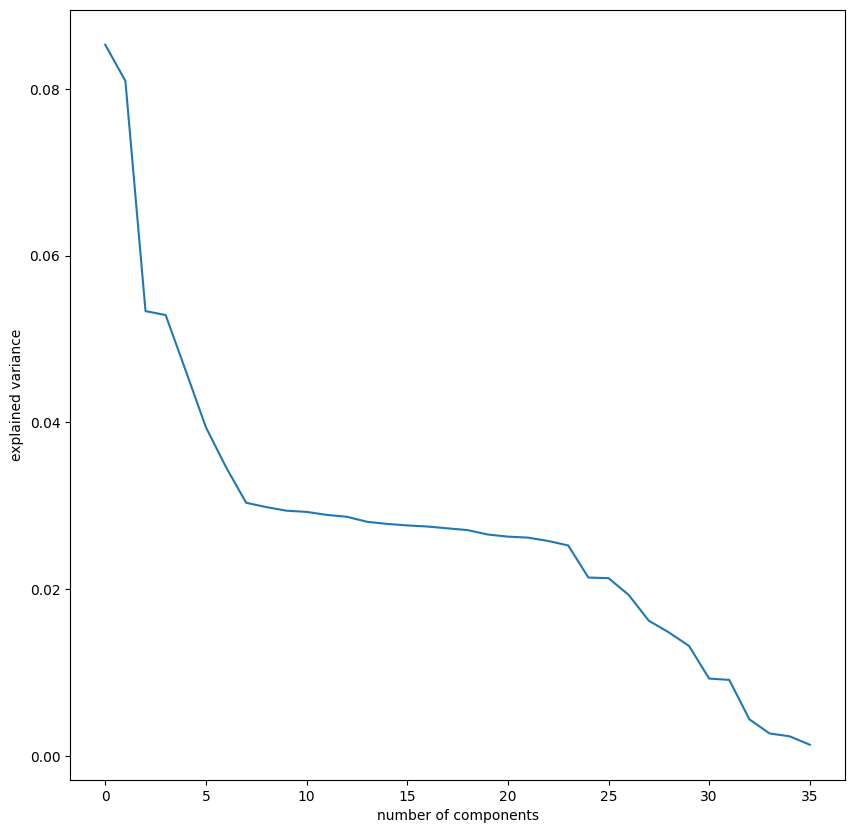

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()

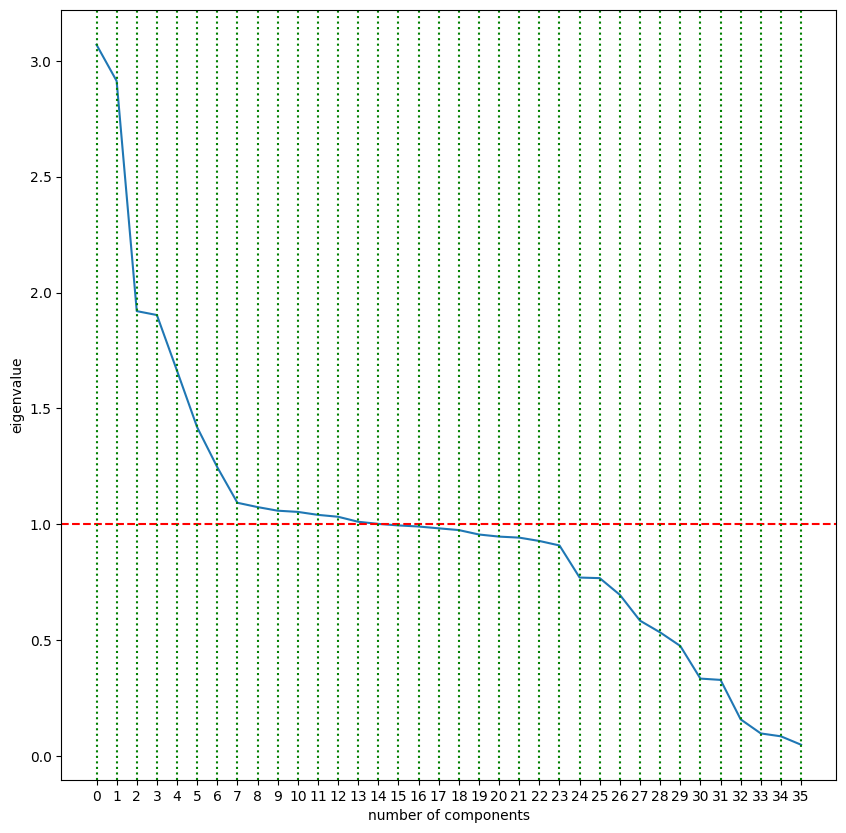

<Figure size 1200x2500 with 0 Axes>

In [50]:
import numpy as np
cov_matrix = np.dot(normalized_df.T, normalized_df) / normalized_df.shape[0]
eigenvalues = [np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)) for eigenvector in pca.components_]

plt.plot(eigenvalues)
plt.xlabel('number of components')
plt.xticks(np.arange(0, normalized_df.shape[1]))
plt.ylabel('eigenvalue')
plt.axhline(y = 1, color = 'r', linestyle = '--')
for tick in range(normalized_df.shape[1]):
    plt.axvline(x = tick, color = 'g', linestyle = ':')
plt.figure(figsize=(12,25), dpi=100)
plt.show() 

In [42]:
loadings = pd.DataFrame(pca.components_.T,
     columns=principle_component_column_names,
     index=normalized_df.columns)
loadings

,PrincipleComponent0,PrincipleComponent1,PrincipleComponent2,PrincipleComponent3,PrincipleComponent4,PrincipleComponent5,PrincipleComponent6,PrincipleComponent7,PrincipleComponent8,PrincipleComponent9,PrincipleComponent10,PrincipleComponent11,PrincipleComponent12,PrincipleComponent13,PrincipleComponent14,PrincipleComponent15,PrincipleComponent16,PrincipleComponent17,PrincipleComponent18,PrincipleComponent19,PrincipleComponent20,PrincipleComponent21,PrincipleComponent22,PrincipleComponent23,PrincipleComponent24,PrincipleComponent25,PrincipleComponent26,PrincipleComponent27,PrincipleComponent28,PrincipleComponent29,PrincipleComponent30,PrincipleComponent31,PrincipleComponent32,PrincipleComponent33,PrincipleComponent34,PrincipleComponent35
Additional_charges,0.023720,-0.008535,-0.408418,0.571431,-0.042061,0.004552,-0.011300,0.021790,0.014181,-0.014858,0.005195,0.008895,0.021991,-0.008632,0.002366,-0.018067,-0.003107,-0.028522,0.005505,-0.018569,-0.032644,0.012529,-0.016288,0.006135,0.006155,-0.006095,-0.013994,0.004809,0.002645,0.002495,-0.001885,-0.014607,0.012292,-0.701339,-0.062869,0.054648
Age,0.014831,-0.008229,-0.283027,0.393247,-0.019072,-0.006546,-0.043982,0.272760,0.085572,-0.193620,0.144868,0.152275,0.063397,0.166368,-0.286724,-0.095084,-0.238351,0.208778,0.132603,-0.205431,0.172603,-0.115982,0.044553,-0.154341,0.043321,0.058876,-0.031141,0.016151,0.002679,-0.016201,0.010783,0.013868,0.002343,0.486884,0.042709,-0.031928
Allergic_rhinitis,-0.002879,-0.010079,-0.022994,0.015880,0.024818,-0.023342,0.011901,-0.137650,0.298626,0.120114,-0.349062,-0.238662,-0.116147,-0.192863,0.194954,0.341252,-0.184103,0.463524,0.123338,-0.322622,-0.049811,-0.302312,-0.123957,0.023207,-0.090856,-0.010536,-0.018247,0.049615,-0.026863,-0.030571,-0.014379,0.009420,0.015875,0.001372,-0.007115,0.008028
Anxiety,0.012486,0.004839,-0.006772,0.019584,-0.037178,0.008294,-0.176207,0.073912,-0.106487,0.164250,0.073518,-0.041849,-0.474047,-0.225494,0.063381,0.234042,-0.472974,-0.397811,-0.132000,-0.062656,0.167990,-0.000021,0.302669,-0.230773,0.053407,-0.018297,0.026063,0.005698,-0.002515,0.030216,-0.010153,0.010376,0.000030,0.006678,0.004275,0.010470
Arthritis,0.016469,-0.013155,0.030628,0.031817,0.013339,-0.020202,-0.055777,0.000037,-0.403445,-0.232992,-0.291328,-0.332485,0.172456,0.044631,-0.074103,-0.135372,-0.270273,-0.002061,0.191293,0.331327,-0.146568,-0.382092,0.323479,0.149712,-0.025160,-0.098210,0.008539,0.015385,0.006580,-0.030130,-0.004381,-0.005720,0.015958,-0.003465,0.001321,0.008749
Asthma,0.010966,-0.020137,-0.006882,0.018517,0.009106,0.091824,-0.031109,0.117702,-0.309679,0.176040,-0.080081,0.408730,-0.093483,0.083941,0.279326,-0.061638,-0.143638,0.493258,-0.231753,0.180270,-0.369062,0.127551,0.093046,-0.251204,-0.003832,-0.014629,0.046295,0.016947,-0.000158,0.024345,-0.010590,-0.001222,0.000303,0.005522,0.001061,0.000239
BackPain,0.028367,-0.010051,-0.034652,0.009010,-0.025161,0.022456,0.034170,-0.104938,0.165942,0.425873,-0.037586,0.338940,0.135944,-0.126706,-0.285642,0.217320,-0.116903,0.005798,0.242389,0.576528,0.203420,-0.162378,-0.136723,-0.003221,0.000633,-0.031944,0.047957,0.017259,0.001271,-0.024704,0.002637,0.004709,0.011823,0.003092,-0.011887,0.010329
Children,-0.006073,0.003052,0.001752,0.019805,0.008089,-0.022583,-0.036643,0.159906,-0.407020,0.100917,0.239698,0.029745,-0.041289,-0.455166,0.173049,-0.149660,0.391583,0.076968,0.176343,-0.092125,0.227887,-0.412831,-0.113084,-0.183808,-0.079417,0.039327,-0.018458,0.011164,-0.001731,-0.009640,0.012071,0.013389,0.009677,0.001697,-0.004972,-0.003841
Diabetes,0.000620,-0.009227,0.009526,-0.013283,0.034092,-0.022638,-0.117418,0.439132,-0.233279,0.054947,-0.222509,-0.032272,0.074968,0.041659,0.232457,0.177574,-0.083286,-0.022017,0.483025,-0.033705,0.194162,0.485859,-0.176826,0.191186,-0.056352,0.016058,0.022575,-0.008011,0.046411,-0.016209,-0.012589,0.007386,0.010790,-0.001014,-0.001960,0.015109
Doc_visits,-0.014026,0.003599,-0.009075,0.016157,-0.009642,-0.002320,0.045750,-0.028159,-0.

In [17]:
pca.explained_variance_ratio_

array([0.08528163, 0.08093208, 0.05333768, 0.05286828, 0.04618595,
       0.03941093, 0.0346226 , 0.03035652, 0.02984073, 0.02940824,
       0.02926316, 0.02890749, 0.02867984, 0.02808023, 0.027824  ,
       0.02764149, 0.02751002, 0.02729345, 0.0270826 , 0.02655222,
       0.02629941, 0.0261782 , 0.02577667, 0.02523819, 0.02139072,
       0.02131937, 0.01931638, 0.01622184, 0.01481298, 0.01318996,
       0.00927473, 0.00911865, 0.00438681, 0.00269834, 0.00235329,
       0.00134531])